In [1]:
import h5py
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gdp
from shapely.affinity import translate

import cartopy.crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
# ASI PRISMA and EO-1 HYPERION
df = pd.DataFrame(
    {'Probe': ['Land', 'Water', 'Wood'],
     'Color': ['#de6b00','#1f78b4','#3FB54B'],
     'Latitude': [-8.61482,-8.7912,-8.7040],
     'Longitude': [116.86549,116.7894,116.8355]})
gdf = gdp.GeoDataFrame(df, crs="EPSG:4326", geometry=gdp.points_from_xy(df.Longitude, df.Latitude))
# sort by label if needed
gdf = gdf.sort_values(by='Probe')
# save to file
gdf.to_file("probs.json", driver="GeoJSON")
gdf

,Probe,Color,Latitude,Longitude,geometry
0,Land,#de6b00,-8.61482,116.86549,POINT (116.86549 -8.61482)
1,Water,#1f78b4,-8.79120,116.78940,POINT (116.78940 -8.79120)
2,Wood,#3FB54B,-8.70400,116.83550,POINT (116.83550 -8.70400)


## Define Metadata

In [3]:
wavelength = [
(520+600)/2, (630+690)/2, (780+860)/2, (1600+1700)/2, (2145+2185)/2, (2185+2225)/2, (2235+2285)/2,
(2295+2365)/2, (2360+2430)/2, (8125+8475)/2, (8475+8825)/2, (8925+9275)/2, (10250+10950)/2, (10950+11650)/2]

## Read Multi-band GeoTiff Dataset (WGS84)

Use gdalbuildvrt tool to produce it from provided multiple GeoTiff files

In [4]:
da = xr.open_rasterio('ASTER_AST_L1T_003_2000_2020.tif')
# scale
#da = da.values/2**14-1
da['band'] = wavelength
#da['fwhm'] = xr.DataArray(fwhm,dims=['band'])
da

<xarray.DataArray (band: 14, y: 1189, x: 1195)>
[19891970 values with dtype=float64]
Coordinates:
  * band     (band) float64 560.0 660.0 820.0 ... 9.1e+03 1.06e+04 1.13e+04
  * y        (y) float64 -8.545 -8.545 -8.545 -8.546 ... -8.864 -8.865 -8.865
  * x        (x) float64 116.7 116.7 116.7 116.7 ... 117.0 117.0 117.0 117.0
Attributes:
    transform:     (0.00026949458523585647, 0.0, 116.71945233857562, 0.0, -0....
    crs:           +init=epsg:4326
    res:           (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:      1
    nodatavals:    (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na...
    scales:        (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1....
    offsets:       (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....
    descriptions:  ('B01', 'B02', 'B3N', 'B04', 'B05', 'B06', 'B07', 'B08', '...

In [5]:
da.min(),da.max()

(<xarray.DataArray ()>
 array(0.003922), <xarray.DataArray ()>
 array(0.931373))

In [6]:
# convert probs to the specified coordinate system
#gdf = gdf.to_crs("EPSG:32750")
#gdf

In [7]:
# bands count
da.band.shape[0]

14

In [8]:
da.band

<xarray.DataArray 'band' (band: 14)>
array([  560.,   660.,   820.,  1650.,  2165.,  2205.,  2260.,  2330.,  2395.,
        8300.,  8650.,  9100., 10600., 11300.])
Coordinates:
  * band     (band) float64 560.0 660.0 820.0 ... 9.1e+03 1.06e+04 1.13e+04

## COPERNICUS/S3/OLCI Bands 15/30/90m

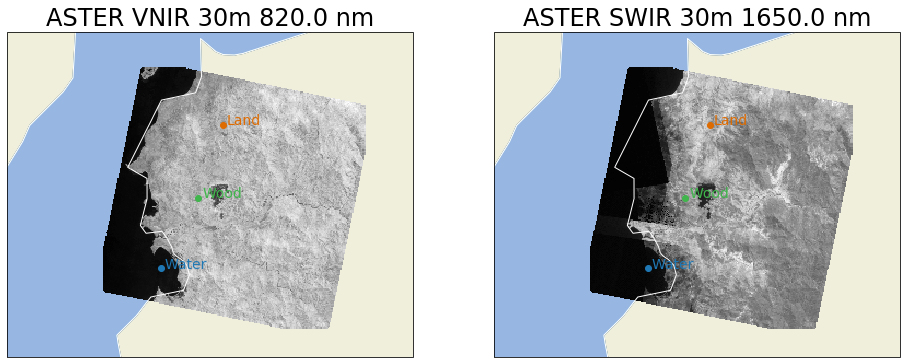

In [9]:
plt.figure(figsize=(16,6))

delta = 0.005

wavelength = 820
band_vnir = da.sel(band=wavelength)

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.coastlines(color='white')
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k')
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='lightblue')
ax1.set_global()
band_vnir[::5,::5].plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greys_r", add_colorbar=False)
ax1.set_xlim([116.6,117.1])
ax1.set_ylim([-8.9,-8.5])
ax1.set_title('ASTER VNIR 30m %.1f nm' % wavelength,fontsize=24)
# Probs
gdf.apply(lambda x: ax1.annotate(xy=translate(x.loc['geometry'],delta).coords[0],
                                 s=x.Probe, color=x.Color, fontsize=14), axis=1)
gdf.apply(lambda x: ax1.scatter(*x.loc['geometry'].coords[0], c=x.Color), axis=1)

wavelength = 1650
band_swir = da.sel(band=wavelength)

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.coastlines(color='white')
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='lightblue')
ax2.set_global()
band_swir[::5,::5].plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(),
                                             cmap="Greys_r", add_colorbar=False)
ax2.set_xlim([116.6,117.1])
ax2.set_ylim([-8.9,-8.5])
ax2.set_title('ASTER SWIR 30m %.1f nm' % wavelength,fontsize=24)
# Probs
gdf.apply(lambda x: ax2.annotate(xy=translate(x.loc['geometry'],delta).coords[0],
                                 s=x.Probe, color=x.Color, fontsize=14), axis=1)
gdf.apply(lambda x: ax2.scatter(*x.loc['geometry'].coords[0], c=x.Color), axis=1)

plt.savefig('ASTER_AST_L1T_003 VNIR and SWIR Bands.jpg', dpi=150, bbox_inches='tight')
plt.show()

## COPERNICUS/S3/OLCI Spectrogram of Probe Locations

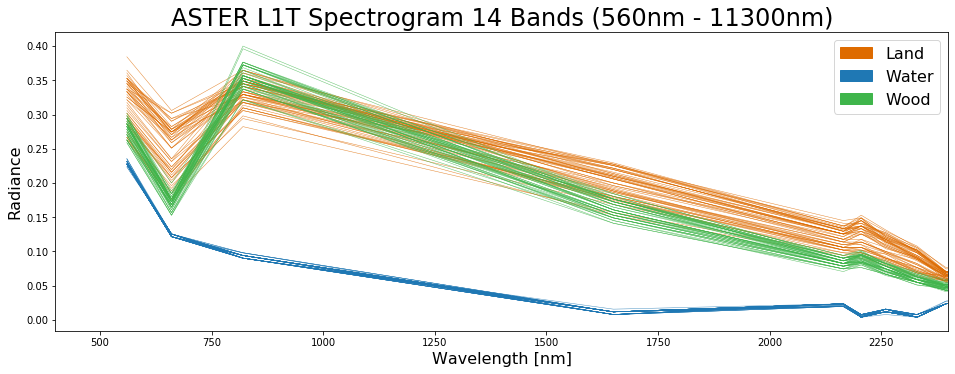

In [10]:
plt.figure(figsize=(16,5.5))
plt.title('ASTER L1T Spectrogram %d Bands (%.0fnm - %.0fnm)' %
          (da.band.shape[0],float(da.band.min()),float(da.band.max())),fontsize=24)
ax = plt.gca()

# for manual legend
patches = []
delta = 1e-3

# plot probes
for (idx,row) in gdf.iterrows():
    #print (row.Probe)
    
    probe = row.Probe
    coords = row.geometry.coords[0]
    color = row.Color

    patches.append(mpatches.Patch(color=color, label=probe))
    da_bands_subset = da.sel(x=slice(coords[0]-delta,coords[0]+delta),y=slice(coords[1]+delta,coords[1]-delta))

    bands_subset = da_bands_subset.to_dataframe(name='value').reset_index().dropna()

    ax = plt.gca()
    for key, grp in bands_subset.groupby(['x','y']):
        grp.plot(ax=ax, kind='line', x='band', y='value', color=color,lw=0.5,alpha=0.8)
    ax.get_legend().remove()

plt.legend(handles=patches, loc='upper right', fontsize=16)

plt.xlabel("Wavelength [nm]",size=16)
plt.ylabel("Radiance",size=16)
plt.xlim([400,2400])
plt.savefig('ASTER_AST_L1T_003 Spectrogram VNIR and SWIR Bands.jpg', dpi=150, bbox_inches='tight')
plt.show()